In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize

#niceties
from rich import print
import seaborn as sns
sns.set()

# #needed
# from ipywidgets import IntProgress
# from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [3]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

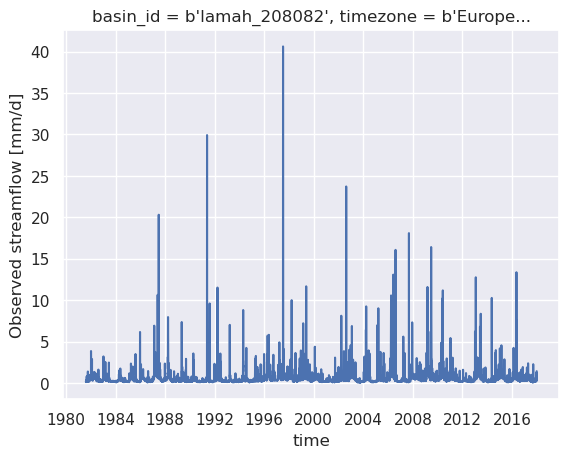

In [6]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
# p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


In [8]:
# def calibrationObjective(modelOutput,observation,start_calibration,end_calibration):
#     # a function that takes in two dataFrames, interpolates the model output to the
#     # observations and calculates the average absolute difference between the two.

#     #combine the two in one dataFrame
#     #hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1, keys = ['model', 'obs'])
#     hydro_data = pd.concat([modelOutput, observation], axis=1, keys = ['model', 'obs'])

#     #only select the calibration period
#     hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
#     hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

#     #calculate mean absolute difference

#     diff = hydro_data['model'] - hydro_data['obs']
#     rms = np.sqrt(np.mean(diff**2))

#     return rms

In [9]:
def objective_function_sorted_maximum(model_output, observation, calibration_start_time, calibration_end_time):
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    model_output.index = model_output.index.tz_localize(None)  # Remove timezone
    observation.index = observation.index.tz_localize(None)
    calibration_start_time = calibration_start_time.tz_localize(None)
    calibration_end_time = calibration_end_time.tz_localize(None)

    model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
    obs_filtered = observation.loc[calibration_start_time:calibration_end_time]
    
    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(obs_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]
    sorted_obs_data_subset = sorted_obs_data[return_periods_years_obs >= 0.5]

    if len(sorted_model_data_subset) is not len (sorted_obs_data_subset):
        raise ValueError("observation and data not equal length")

    objective_this_model = np.sqrt(np.mean((sorted_model_data_subset - sorted_obs_data_subset)**2))

    return objective_this_model

In [10]:
# Q_pandas = ds_forcing["Q"].to_dataframe()

# def optimization_function(parameter_vector):
#     model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
#     config_file, _ = model.setup(            parameters = parameter_vector,
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_",
#                                )
#     model.initialize(config_file)


#    # discharge_this_timestep = model.get_value("Q") 
#     Q_m = []
#     time = []
#     while model.time < model.end_time:
#         model.update()
#         discharge_this_timestep = model.get_value("Q")
#         Q_m.append(discharge_this_timestep[0])
#         time.append(pd.Timestamp(model.time_as_datetime.date()))
#    # model.finalize()
#    # print(model.get_value("Q"))

#     #calculate the objective function 
#     discharge_dataframe = pd.DataFrame({'Modelled_discharge': Q_m}, index=pd.to_datetime(time))
#     objective_this_model = objective_function_sorted_maximum(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
#     del Q_m, time, discharge_dataframe
   
#     if np.isnan(objective_this_model):
#         return np.inf
    
#     return objective_this_model

In [11]:
######## NEW

Q_pandas = ds_forcing["Q"].to_dataframe()
# obs_all_dataframe = ds_forcing.to_dataframe() 
# obs_series = obs_all_dataframe["Q"]

def optimization_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)
    
    objective_this_model = objective_function_sorted_maximum(discharge_series,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    del Q_m, time, discharge_series
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [12]:
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result = minimize(optimization_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [13]:
# result

In [14]:
# result.x
# 90/10
# # result = [6.51669781e-05, 6.38655600e-01, 5.30024294e+01, 1.56641841e+00,
# #        1.10734080e+00, 1.49999999e+00, 5.50209588e-01, 3.74966606e-02,
# #        1.04773070e+00]

# 70/30
# result = [5.15724216e-05, 8.36587345e-01, 3.90778393e+01, 3.57466531e+00,
#        1.06383450e+00, 9.37562028e-01, 3.02412699e-01, 8.15566365e-02,
#        2.90551458e+00]

result = [4.00431542e-07, 1.18207742e+00, 6.18107025e+01, 3.43810639e+00,
       1.46429514e+00, 1.50000000e+00, 6.12583301e-01, 2.73318870e-03,
       7.95615325e-01]

In [15]:
# result.fun
# 90/10
# # objective = 0.027397519552779696

# 70/30
# objective = 0.01965939310646257



In [16]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)


In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [18]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

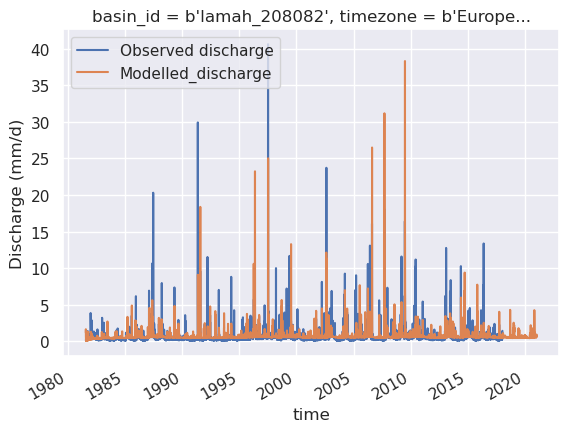

In [19]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [20]:
df = pd.DataFrame(model_output)

calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

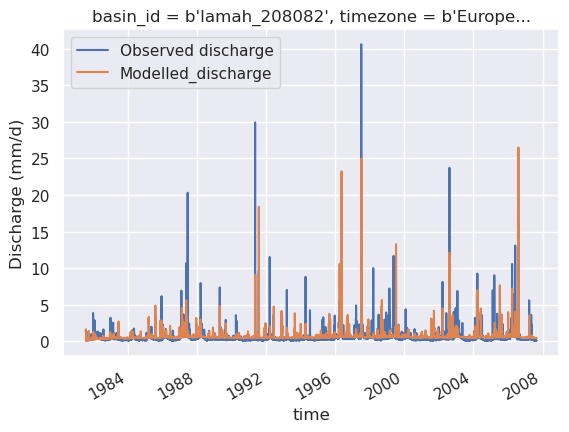

In [21]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

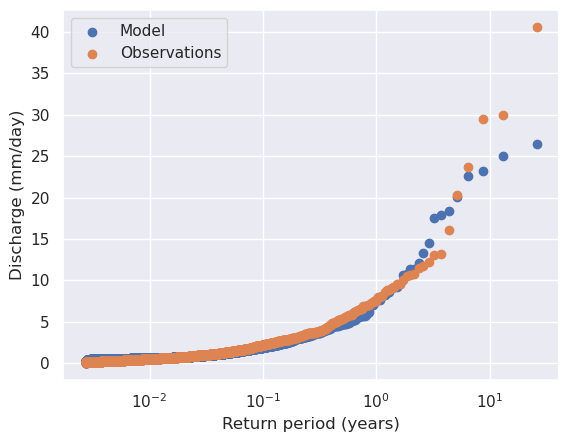

In [22]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

In [23]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)
# Filter de modeloutput voor de geselecteerde periode
model_output_filtered = model_output.loc[validation_start_time:validation_end_time]

# Als je ook de waargenomen afvoer wilt filteren, doe je hetzelfde:
ds_forcing_filtered = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

Text(0, 0.5, 'Discharge (mm/d)')

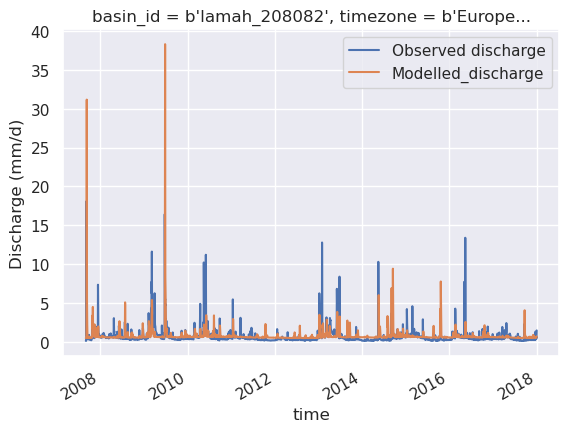

In [24]:
ds_forcing_filtered.plot(label="Observed discharge")
model_output_filtered.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

Text(0, 0.5, 'Discharge (mm/day)')

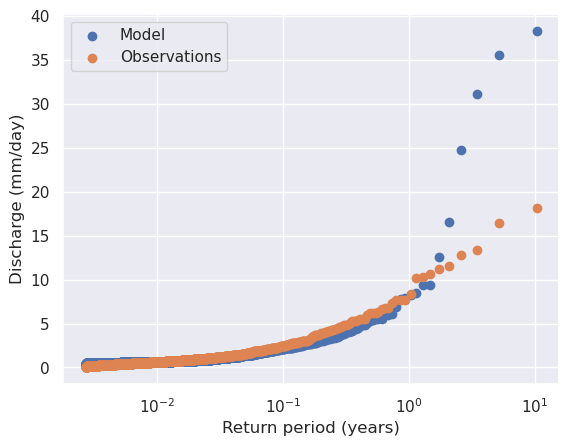

In [25]:
# Sort data from high to low
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below.

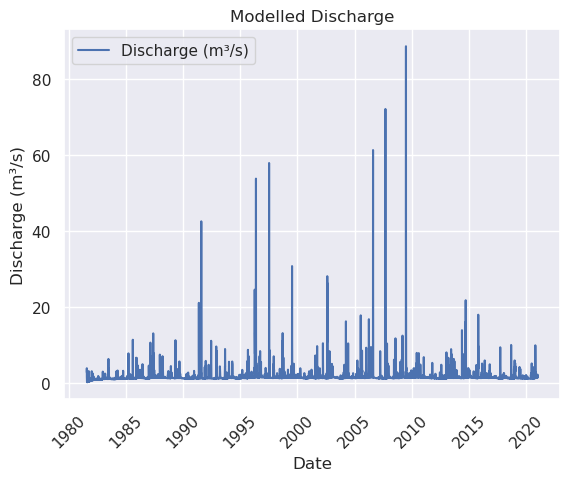

In [26]:
catchment_area = ds_forcing["area"].values


model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

plt.plot(df.index, model_data, label='Discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
plt.show()

In [27]:
# from scipy.optimize import curve_fit
# from scipy.optimize import fsolve

# # Sort data from high to low
# sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

# #calculate return periods
# m = len(sorted_model_data)
# rank = np.arange(1, m + 1)
# return_periods_days_model = (m + 1) / rank
# return_periods_years_model = return_periods_days_model / 365


# # 0.5 because we want to extrapolate the peaks, so look at discharges that occure 2 times a year or more
# return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 0]
# sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0]

# def fit_function(x, a, b, c, d, e):
#     return (a * np.log10(x)**4 + b * np.log10(x)**3 + c * np.log10(x)**2 + 
#             d * np.log10(x) + e)

# # Voer curve fitting uit
# params, params_covariance = curve_fit(fit_function, return_periods_years_model, sorted_model_data)

# # Genereer gefitte lijn met uitgebreid bereik
# x_extended = np.logspace(-2, 5, num=100)  # Breid x-bereik uit van 10^-2 tot 10^5
# line_extended = fit_function(x_extended, params[0], params[1], params[2], params[3],
#                              params[4])


# # plt.plot(x_extended, line_extended, color='blue', label='Fitted line')


# # Functie om x te vinden voor een gegeven y-waarde
# def find_x_for_y(y_value):
#     # Definieer de vergelijking om op te lossen
#     def equation_to_solve(x):
#         return fit_function(x, params[0], params[1], params[2], params[3], params[4]) - y_value
    
#     # Gebruik een root-finding algoritme om de x-waarde te vinden
#     x_solution = fsolve(equation_to_solve, x0=1)  # Initiële gok x0=1
#     return x_solution[0]

# # Voorbeeld: Vind x voor een gegeven y-waarde
# y_value = 530
# x_value = find_x_for_y(y_value)
# print(f"Voor y = {y_value}, de overeenkomstige x-waarde is {x_value}")




# def power_law(x, a, b):
#     return a * x ** b

# params, _ = curve_fit(power_law, return_periods_years_model_subset, sorted_model_data_subset, maxfev=10000)

# a_opt, b_opt = params

# x_fit = np.logspace(np.log(min(return_periods_years_model_subset)), np.log(max(return_periods_years_model_subset)), 1000)
# y_fit = power_law(x_fit, a_opt, b_opt)

# def find_x_for_y(y_target, a, b):
#     return (y_target / a) ** (1 / b)

# y_target = 530
# x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For y = {y_target}, the x_value is {x_value}")

# plt.xscale('log')
# plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
# plt.plot(x_fit, y_fit)
# plt.xlabel('Return period (years)')
# plt.ylabel('Discharge (m3/s)')

# plt.hlines(y_target, xmin=min(return_periods_years_model), xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
# plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
# plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  # X-label net onder de as
# plt.text(min(return_periods_years_model) / 2, y_target, f'{y_target:.0f} $m^3/s$', va='center', fontsize=12, color='black')  # Y-label links naast lijn


# plt.title('Modelled extrapolation')
# plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/Scatter.png", dpi=300)

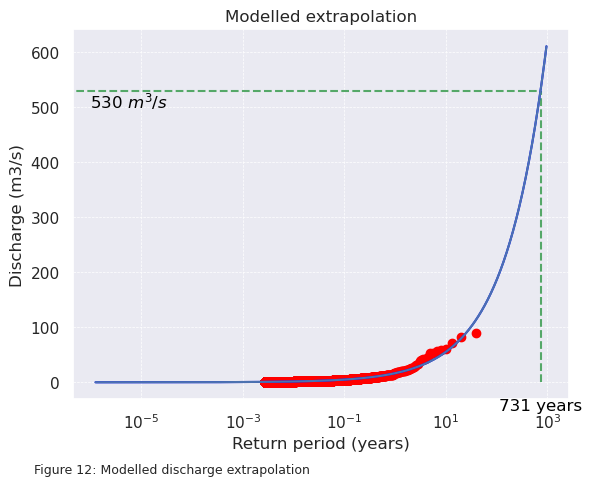

In [28]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365


# # 0.5 because we want to extrapolate the peaks, so look at discharges that occure 2 times a year or more
# return_periods_years_model_subset = return_periods_years_model[return_periods_years_model >= 0.5]
# sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]

def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=10000)
    a_opt, b_opt = params

    x_fit = np.logspace(np.log(min(return_periods_years_subset)), np.log(max(return_periods_years_subset)/2), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt

x_fit, y_fit, a_opt, b_opt = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')
plt.text(0.000001, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.plot(x_fit, y_fit, color='blue')

plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden")
plt.plot(x_fit, y_fit)
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')




plt.title('Modelled extrapolation')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.2, -0.2, "Figure 12: Modelled discharge extrapolation", 
         ha="center", fontsize=9, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/Scatter.png", dpi=300)

In [29]:
df['Modelled_discharge'].dropna(inplace=True)
Q_pandas["Q"].dropna(inplace=True)

validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

df_filtered = df[(df.index >= validation_start_time) & (df.index <= validation_end_time)]
Q_filtered = Q_pandas[(Q_pandas.index >= validation_start_time) & (Q_pandas.index <= validation_end_time)]

print(f'The objective for the validation period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], validation_start_time, validation_end_time)}')

The objective for the validation period is 7.980948622784268

In [30]:
print(f'The objective for the calibration period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], calibration_start_time, calibration_end_time)}')

The objective for the calibration period is 2.555659777993916